# Occasionally binding constraint model - Solved with ANN (Flux.jl)

This notebook solves the Bianchi (2011) model with occasionally binding collateral constraints using an Artificial Neural Network approach.

**Method**: Fischer-Burmeister complementarity formulation with neural network approximation

## Setup: Load Required Packages

In [1]:
using Flux
using Plots
using ProgressMeter
using LaTeXStrings
using Random
using Statistics
using Distributions
using Flux.NNlib
using CUDA
using cuDNN

┌ Error: This version of CUDA.jl only supports NVIDIA drivers for CUDA 11.x or 12.x (yours is for CUDA 13.0.0)
└ @ CUDA /home/tdtulo/.julia/packages/CUDA/ja0IX/src/initialization.jl:70


## GPU Device Selection

Check if CUDA is available for GPU acceleration. The code will automatically fall back to CPU if not.

In [2]:
if CUDA.has_cuda()
    @info "CUDA is on"
    CUDA.allowscalar(false)
    const device = gpu
else
    @info "CUDA is off"
    const device = cpu
end

┌ Info: CUDA is off
└ @ Main /home/tdtulo/Desktop/HDDP_github/high_dim_DP/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:6


cpu (generic function with 1 method)

## Model Calibration

Standard parameters from Bianchi (2011):
- σ: Risk aversion
- κ: Borrowing constraint parameter
- β: Discount factor
- ω: Weight on traded goods
- η: Elasticity of substitution

In [3]:
# Precision type (Float32 for faster GPU computation)
const FTYPE = Float32

# Structural parameters
const σ   = FTYPE(2.0)       # Inverse of intertemporal elasticity
const κ   = FTYPE(0.2808)    # Borrowing constraint parameter
const β   = FTYPE(0.91)      # Discount factor
const ω   = FTYPE(0.31)      # Weight on traded goods
const η   = FTYPE(0.5)       # Elasticity of substitution
const δ   = FTYPE(0.14)      # Bond duration
const τ   = FTYPE(0.2)       # Tax rate

# Endowments
const yT  = FTYPE(1.0)       # Traded goods
const yN  = FTYPE(1.0)       # Non-traded goods

# Debt grid
const l_min, l_max = FTYPE(0.1), FTYPE(0.9)
const n_l = 300
const l_grid = collect(range(l_min, l_max, length=n_l))

# Interest rate
const i_l = FTYPE(0.05)

println("Model calibrated with σ=$σ, κ=$κ, β=$β")

Model calibrated with σ=2.0, κ=0.2808, β=0.91


## Stochastic Shocks

The model includes two shocks:
1. **ν**: Government default cost
2. **φ**: Private sector default rate

These are discretized into 25 states with transition matrix Π.

In [4]:
# Pre-computed transition matrix (25x25)
const Π = FTYPE.([
    2.1212e-01 5.3030e-01 0.0000e+00 0.0000e+00 0.0000e+00 1.2121e-01 1.3636e-01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    1.7268e-02 4.6834e-01 2.5432e-01 5.2329e-04 0.0000e+00 7.8493e-03 1.6431e-01 8.6866e-02 5.2329e-04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 8.7662e-02 5.5571e-01 8.9786e-02 0.0000e+00 0.0000e+00 3.1087e-02 2.0429e-01 3.1280e-02 1.9309e-04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 2.4401e-01 4.7631e-01 2.0886e-02 0.0000e+00 0.0000e+00 8.1508e-02 1.6913e-01 8.1508e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 3.9423e-01 3.0769e-01 0.0000e+00 0.0000e+00 9.6154e-03 1.2500e-01 1.6346e-01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    3.3784e-03 5.0676e-03 0.0000e+00 0.0000e+00 0.0000e+00 3.3615e-01 5.1464e-01 1.0135e-02 0.0000e+00 0.0000e+00 5.0113e-02 7.9392e-02 1.1261e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    3.0430e-04 8.0991e-03 4.0963e-03 2.3408e-05 0.0000e+00 2.0458e-02 5.4219e-01 2.8665e-01 1.1938e-03 0.0000e+00 3.3473e-03 8.6234e-02 4.7213e-02 1.8726e-04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 1.4610e-03 8.4155e-03 1.3157e-03 1.7087e-05 1.1107e-04 1.0535e-01 6.4296e-01 1.0445e-01 1.2815e-04 5.1262e-05 1.5806e-02 1.0315e-01 1.6771e-02 1.7087e-05 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 2.3579e-05 4.1500e-03 8.2999e-03 4.9517e-04 0.0000e+00 1.1082e-03 2.8830e-01 5.3869e-01 2.2330e-02 0.0000e+00 3.3011e-04 4.7701e-02 8.5640e-02 2.9238e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 7.2765e-03 4.1580e-03 0.0000e+00 0.0000e+00 6.2370e-03 5.0260e-01 3.4719e-01 0.0000e+00 0.0000e+00 5.1975e-04 7.6403e-02 5.5613e-02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.1251e-02 2.8537e-02 4.0478e-04 0.0000e+00 0.0000e+00 3.6733e-01 5.3269e-01 9.1075e-03 0.0000e+00 0.0000e+00 1.4572e-02 2.6108e-02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.3778e-03 3.1569e-02 1.7214e-02 1.0333e-04 0.0000e+00 2.2389e-02 5.7034e-01 3.0483e-01 1.4036e-03 0.0000e+00 1.4208e-03 3.1638e-02 1.7610e-02 1.0333e-04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.2406e-05 6.0946e-03 3.7033e-02 6.1442e-03 1.5508e-05 1.0545e-04 1.1019e-01 6.7863e-01 1.0985e-01 1.3337e-04 3.1016e-06 6.3862e-03 3.9043e-02 6.3613e-03 9.3047e-06 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 9.4763e-05 1.6859e-02 3.1746e-02 1.3611e-03 0.0000e+00 1.5076e-03 3.0492e-01 5.6999e-01 2.3053e-02 0.0000e+00 5.1689e-05 1.7006e-02 3.1780e-02 1.6282e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.0727e-04 2.7245e-02 1.9576e-02 0.0000e+00 0.0000e+00 9.0817e-03 5.3966e-01 3.5015e-01 0.0000e+00 0.0000e+00 0.0000e+00 3.1887e-02 2.1594e-02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.8564e-02 8.0663e-02 2.2099e-03 0.0000e+00 0.0000e+00 3.4088e-01 4.9558e-01 9.3923e-03 0.0000e+00 0.0000e+00 4.4199e-03 8.2873e-03 0.0000e+00 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.3449e-03 8.5006e-02 4.7474e-02 2.5375e-04 0.0000e+00 2.0992e-02 5.3746e-01 2.9186e-01 1.4994e-03 0.0000e+00 2.5375e-04 7.6125e-03 4.1753e-03 6.9204e-05 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.5060e-05 1.6982e-02 1.0494e-01 1.6581e-02 4.1767e-05 1.4201e-04 1.0634e-01 6.3816e-01 1.0536e-01 1.2530e-04 0.0000e+00 1.3532e-03 8.5288e-03 1.4117e-03 8.3534e-06;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0451e-04 4.5219e-02 8.4735e-02 3.7948e-03 0.0000e+00 1.7270e-03 2.8756e-01 5.4286e-01 2.3041e-02 0.0000e+00 4.5446e-05 3.4539e-03 7.0896e-03 2.7268e-04;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 9.3781e-02 4.8144e-02 0.0000e+00 0.0000e+00 1.2036e-02 5.0752e-01 3.2297e-01 0.0000e+00 0.0000e+00 0.0000e+00 9.0271e-03 6.5196e-03;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e-01 1.1667e-01 0.0000e+00 0.0000e+00 0.0000e+00 2.1667e-01 4.5000e-01 1.6667e-02 0.0000e+00 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.3420e-03 1.6788e-01 9.2284e-02 1.0428e-03 0.0000e+00 1.4599e-02 4.5203e-01 2.6173e-01 2.0855e-03 0.0000e+00;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.7276e-02 1.8443e-01 2.8902e-02 1.8064e-04 0.0000e+00 9.2666e-02 5.7225e-01 9.4111e-02 1.8064e-04;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.6089e-02 1.8058e-01 6.8241e-03 0.0000e+00 1.0499e-03 2.6772e-01 4.3832e-01 1.9423e-02;
    0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.3793e-01 9.1954e-02 0.0000e+00 0.0000e+00 1.1494e-02 4.9425e-01 2.6437e-01;
])

# Shock grid (25 x 2): [ν, φ]
const S = FTYPE.([
    -1.1021e-03  3.3916e-03;
    -1.1021e-03  8.4394e-03;
    -1.1021e-03  2.1000e-02;
    -1.1021e-03  5.2255e-02;
    -1.1021e-03  1.3003e-01;
     9.0945e-01  3.3916e-03;
     9.0945e-01  8.4394e-03;
     9.0945e-01  2.1000e-02;
     9.0945e-01  5.2255e-02;
     9.0945e-01  1.3003e-01;
     1.8200e+00  3.3916e-03;
     1.8200e+00  8.4394e-03;
     1.8200e+00  2.1000e-02;
     1.8200e+00  5.2255e-02;
     1.8200e+00  1.3003e-01;
     2.7306e+00  3.3916e-03;
     2.7306e+00  8.4394e-03;
     2.7306e+00  2.1000e-02;
     2.7306e+00  5.2255e-02;
     2.7306e+00  1.3003e-01;
     3.6411e+00  3.3916e-03;
     3.6411e+00  8.4394e-03;
     3.6411e+00  2.1000e-02;
     3.6411e+00  5.2255e-02;
     3.6411e+00  1.3003e-01;
])

const ν_grid  = S[:,1]  # Government default cost
const ϕ_grid  = S[:,2]  # Private default rate
const n_s = size(S,1)   # Number of states (25)

println("Shocks discretized: $n_s states")

Shocks discretized: 25 states


## Economic Functions

Key equilibrium conditions:
- Marginal utility of traded consumption
- Non-traded goods price (from intratemporal FOC)

In [5]:
# Marginal utility of traded consumption
∂u∂cT(ct, yn; ω_p=ω, η_p=η, σ_p=σ) = ct > 0 ? 
    ω_p * ct^(-1/η_p) * (ω_p*ct^((η_p-1)/η_p) + (1-ω_p)*yn^((η_p-1)/η_p))^((1-σ_p*η_p)/(η_p-1)) : 
    FTYPE(999_999.0)

# Price of non-traded goods (from intratemporal optimality)
price_nt(ct, yn; ω_p=ω, η_p=η) = (1-ω_p)/ω_p * (max(ct, FTYPE(1e-9)) / yn)^(1/η_p)

price_nt (generic function with 1 method)

## Neural Network Architecture

**Input**: 3D state (l, ν, φ)  
**Output**: Policy l' ∈ [l_min, l_max]  
**Architecture**: 3 → 256 → 128 → 1 with ReLU activations

In [6]:
const state_dim = 3
const policy_dim = 1
const Q1 = 256
const Q2 = 128
activation_f = relu
const T_sigmoid = FTYPE(1.0)

# Build network: maps normalized state to policy
model = Chain(
    Dense(state_dim, Q1, activation_f),
    Dense(Q1, Q2, activation_f),
    Dense(Q2, policy_dim),
    x -> l_min .+ (l_max - l_min) .* Flux.sigmoid(x ./ T_sigmoid)
)

println("Network created with $(sum(length, Flux.params(model))) parameters")

┌ Warning: `Flux.params(m...)` is deprecated. Use `Flux.trainable(model)` for parameter collection,
│ and the explicit `gradient(m -> loss(m, x, y), model)` for gradient computation.
└ @ Flux /home/tdtulo/.julia/packages/Flux/uRn8o/src/deprecations.jl:93


Network created with 34049 parameters


## Training Setup

**Optimizer**: AdaBelief with two-stage learning rate  
**Epochs**: 50,000 (warmup at 30,000)  
**Batch size**: 32

In [7]:
const initial_learning_rate = FTYPE(1e-3)
const final_learning_rate = FTYPE(1e-6)
const epochs_warmup = 30000
const epochs = 50000
const batch_size = 32

opt = AdaBelief(initial_learning_rate)
st = Flux.setup(opt, model)

(layers = ((weight = Leaf(AdaBelief(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-16), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(AdaBelief(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-16), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(AdaBelief(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-16), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(AdaBelief(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-16), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## State Normalization

Normalize shocks but keep debt in original scale for better training.

In [8]:
const shock_mean = mean(S, dims=1)'
const shock_std = std(S, dims=1)'

function normalize_state(batch)
    l = batch[1:1, :]
    shocks = batch[2:3, :]
    normalized_shocks = (shocks .- shock_mean) ./ (2 .* shock_std)
    return vcat(l, normalized_shocks)
end

function sample_states(batch_size::Int)
    # Sample debt uniformly
    loans = rand(FTYPE, 1, batch_size) .* (l_max - l_min) .+ l_min
    # Sample shocks
    shock_indices = rand(1:n_s, batch_size)
    shocks_ν = S[shock_indices, 1]'
    shocks_ϕ = S[shock_indices, 2]'
    return vcat(loans, shocks_ν, shocks_ϕ), shock_indices
end

sample_states (generic function with 1 method)

## Loss Function: Fischer-Burmeister

The FB function handles complementarity:  
FB(a, b) = a + b - √(a² + b²)  

Where:
- a = Euler equation residual
- b = Constraint slack

At optimum, FB = 0 whether constraint binds or not.

In [9]:
const huber_delta = FTYPE(0.1)

function huber_loss(x, δ)
    abs_x = abs.(x)
    return Flux.mean(ifelse.(abs_x .< δ, FTYPE(0.5) .* x.^2, δ .* (abs_x .- FTYPE(0.5) * δ)))
end

function ann_loss(m, batch::AbstractMatrix, shock_indices::Vector{Int})
    current_batch_size = size(batch, 2)
    normalized_batch = normalize_state(batch)
    l, ν, ϕ = batch[1:1, :], batch[2:2, :], batch[3:3, :]

    # Current policy
    lp = m(normalized_batch)
    ct = yT*(1-τ) .- l .* (FTYPE(1.0) .- ϕ) .+ lp ./ (FTYPE(1.0) + i_l)
    pn = price_nt.(ct, yN)

    # Vectorized expectation: evaluate ALL future states at once
    lp_expanded = repeat(lp, inner=(1, n_s))
    S_tiled = repeat(S', 1, current_batch_size)
    state_prime_unnormalized = vcat(lp_expanded, S_tiled)
    lpp = m(normalize_state(state_prime_unnormalized))
    ϕ_p_tiled = state_prime_unnormalized[3:3, :]
    ct_prime = yT*(1-τ) .- lp_expanded .* (FTYPE(1.0) .- ϕ_p_tiled) .+ lpp ./ (FTYPE(1.0) + i_l)
    future_marg_utils = ∂u∂cT.(ct_prime, yN)
    
    # Compute expectations
    future_marg_utils_reshaped = reshape(future_marg_utils, n_s, current_batch_size)
    E_λp = Π' * future_marg_utils_reshaped
    cartesian_indices = CartesianIndex.(shock_indices, 1:current_batch_size)
    E_λp_final = E_λp[cartesian_indices]'

    # Fischer-Burmeister residual
    λ = ∂u∂cT.(ct, yN)
    borr_const = κ .* (pn .* yN .+ yT*(1-τ))
    epsilon = FTYPE(1e-9)
    a_norm = FTYPE(1.0) .- (β .* E_λp_final .* (FTYPE(1.0) + i_l)) ./ (λ .+ epsilon)
    b_norm = FTYPE(1.0) .- lp ./ (borr_const .+ epsilon)
    fb_residual = a_norm .+ b_norm .- sqrt.(a_norm.^2 .+ b_norm.^2)
    
    return huber_loss(fb_residual, huber_delta)
end

ann_loss (generic function with 1 method)

## Multiplier Recovery Function

After training, we can recover the Kuhn-Tucker multiplier μ to see where the constraint binds.

In [10]:
function recover_multiplier(m, batch::AbstractMatrix, shock_indices::Vector{Int})
    current_batch_size = size(batch, 2)
    normalized_batch = normalize_state(batch)
    l, ν, ϕ = batch[1:1, :], batch[2:2, :], batch[3:3, :]
    lp = m(normalized_batch)
    ct = yT*(1-τ) .- l .* (FTYPE(1.0) .- ϕ) .+ lp ./ (FTYPE(1.0) + i_l)

    # Same vectorized expectation as in loss
    lp_expanded = repeat(lp, inner=(1, n_s))
    S_tiled = repeat(S', 1, current_batch_size)
    state_prime_unnormalized = vcat(lp_expanded, S_tiled)
    lpp = m(normalize_state(state_prime_unnormalized))
    ϕ_p_tiled = state_prime_unnormalized[3:3, :]
    ct_prime = yT*(1-τ) .- lp_expanded .* (FTYPE(1.0) .- ϕ_p_tiled) .+ lpp ./ (FTYPE(1.0) + i_l)
    future_marg_utils = ∂u∂cT.(ct_prime, yN)
    future_marg_utils_reshaped = reshape(future_marg_utils, n_s, current_batch_size)
    E_λp = Π' * future_marg_utils_reshaped
    cartesian_indices = CartesianIndex.(shock_indices, 1:current_batch_size)
    E_λp_final = E_λp[cartesian_indices]'

    # Multiplier from Euler equation
    λ = ∂u∂cT.(ct, yN)
    μ = λ ./ (FTYPE(1.0) + i_l) .- β .* E_λp_final
    return μ
end

recover_multiplier (generic function with 1 method)

## Training Loop

Train for 50,000 epochs with learning rate decay at epoch 30,000.

In [11]:
println("--- Starting ANN Training ---")
losses = FTYPE[]
p_bar = Progress(epochs; desc="Training Policy ANN:")

for epoch in 1:epochs
    # Switch to lower learning rate at warmup point
    if epoch == epochs_warmup
        println("\n--- Switched to final learning rate: $(final_learning_rate) ---")
        global opt = ADAM(final_learning_rate)
        global st  = Flux.setup(opt, model)
    end
    
    # Sample batch and compute loss
    batch, shock_indices = sample_states(batch_size)
    loss, grads = Flux.withgradient(m -> ann_loss(m, batch, shock_indices), model)
    Flux.update!(st, model, grads[1])
    push!(losses, loss)

    ProgressMeter.next!(p_bar; showvalues=[(:epoch, epoch), (:loss, loss)])
end

println("--- Training Complete ---")

--- Starting ANN Training ---


Training Policy ANN:   0%|                               |  ETA: 13.99 days

Training Policy ANN:   1%|▎                              |  ETA: 1:41:39

Training Policy ANN:   1%|▎                              |  ETA: 1:36:46

Training Policy ANN:   1%|▎                              |  ETA: 1:32:20

Training Policy ANN:   1%|▎                              |  ETA: 1:28:41

Training Policy ANN:   1%|▍                              |  ETA: 1:25:29

Training Policy ANN:   1%|▍                              |  ETA: 1:22:12

Training Policy ANN:   1%|▍                              |  ETA: 1:19:20

Training Policy ANN:   1%|▍                              |  ETA: 1:16:55

Training Policy ANN:   1%|▍                              |  ETA: 1:14:40

Training Policy ANN:   1%|▍                              |  ETA: 1:12:32

Training Policy ANN:   1%|▍                              |  ETA: 1:10:39

Training Policy ANN:   1%|▍                              |  ETA: 1:08:46

Training Policy ANN:   1%|▍        


--- Switched to final learning rate: 1.0e-6 ---




Training Policy ANN:  60%|██████████████████▋            |  ETA: 0:02:59

Training Policy ANN:  60%|██████████████████▋            |  ETA: 0:02:59

Training Policy ANN:  60%|██████████████████▋            |  ETA: 0:02:59

Training Policy ANN:  60%|██████████████████▋            |  ETA: 0:02:59

Training Policy ANN:  60%|██████████████████▋            |  ETA: 0:02:58

Training Policy ANN:  60%|██████████████████▋            |  ETA: 0:02:58

Training Policy ANN:  60%|██████████████████▋            |  ETA: 0:02:58

Training Policy ANN:  60%|██████████████████▊            |  ETA: 0:02:58

Training Policy ANN:  60%|██████████████████▊            |  ETA: 0:02:57

Training Policy ANN:  60%|██████████████████▊            |  ETA: 0:02:57

Training Policy ANN:  60%|██████████████████▊            |  ETA: 0:02:57

Training Policy ANN:  60%|██████████████████▊            |  ETA: 0:02:57

Training Policy ANN:  60%|██████████████████▊            |  ETA: 0:02:57

Training Policy ANN:  60%|██████████

## Visualize Results

Plot:
1. Training loss convergence
2. Learned policy function
3. Kuhn-Tucker multiplier

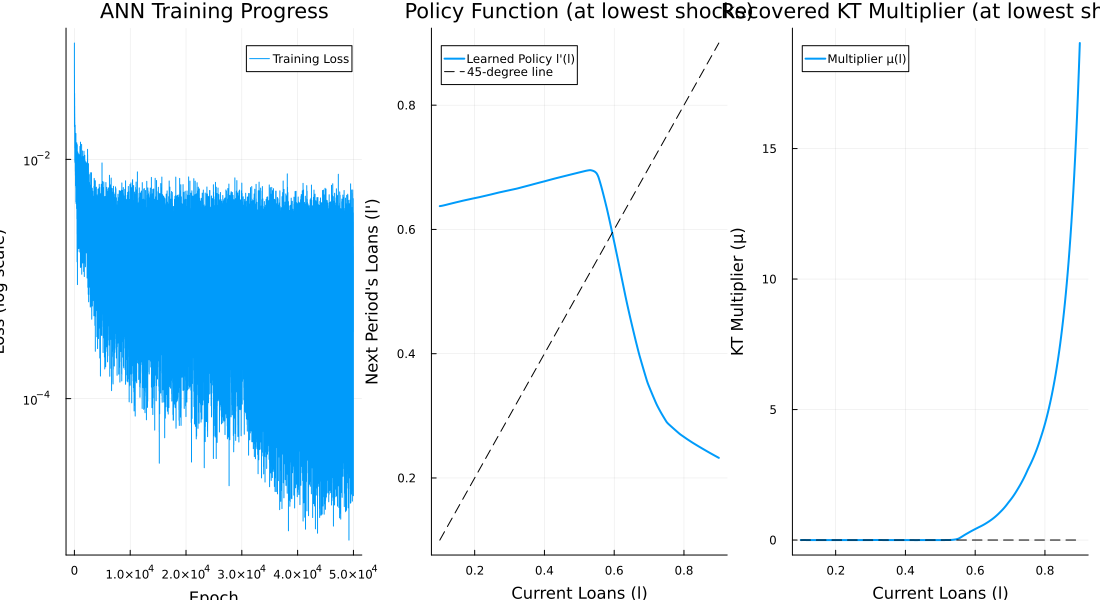

In [12]:
# Loss plot
p1 = plot(losses,
          label="Training Loss",
          xlabel="Epoch",
          ylabel="Loss (log scale)",
          title="ANN Training Progress",
          yaxis=:log10,
          legend=:topright)

# Prepare plotting grid (at lowest shocks)
println("Plotting learned policy function...")
plot_l_grid = l_grid
plot_ν_grid = fill(ν_grid[1], n_l)
plot_ϕ_grid = fill(ϕ_grid[1], n_l)
plot_grid_unnormalized = vcat(plot_l_grid', plot_ν_grid', plot_ϕ_grid')
plot_shock_indices = fill(1, n_l)

learned_policy = model(normalize_state(plot_grid_unnormalized))

# Policy plot
p2 = plot(l_grid, learned_policy',
          label="Learned Policy l'(l)",
          xlabel="Current Loans (l)",
          ylabel="Next Period's Loans (l')",
          title="Policy Function (at lowest shocks)",
          linewidth=2,
          legend=:topleft)
plot!(l_grid, l_grid,
      linestyle=:dash,
      color=:black,
      label="45-degree line")

# Multiplier plot
println("Recovering and plotting KT multiplier...")
recovered_mu = recover_multiplier(model, plot_grid_unnormalized, plot_shock_indices)

p3 = plot(l_grid, recovered_mu',
          label="Multiplier μ(l)",
          xlabel="Current Loans (l)",
          ylabel="KT Multiplier (μ)",
          title="Recovered KT Multiplier (at lowest shocks)",
          linewidth=2,
          legend=:topleft)
plot!(l_grid, zeros(FTYPE, n_l),
      linestyle=:dash,
      color=:black,
      label="")

# Combine plots
plt = plot(p1, p2, p3, layout=(1,3), size=(1100, 600))
display(plt)

# Save figure
# savefig(plt, "Collateral_Constraint_ANN_Results.png")
# println("Figure saved as Collateral_Constraint_ANN_Results.png")

## Interpretation

**Policy Function**: Shows characteristic kink where borrowing constraint starts to bind

**Multiplier μ**: 
- μ = 0: Constraint not binding (interior solution)
- μ > 0: Constraint binds (household wants to borrow more)

The kink location indicates the threshold debt level where sudden stops occur.